# Classification Algorithms

## Perceptron

Though we implemented a **perceptron** from scratch, we can train one directly from **Scikit Learn**. We will continue using the *Iris* dataset.

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

To better measure performance we have to split the data into **training** and **test** set.

In [3]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

As we may recall, standardizing features is a best practice before training.

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Since the perceptron is already implemented efficiently, this time we can use all 3 classes and not just 2.

In [5]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(n_iter=40, eta0=0.01, random_state=0) # with random_state=0 we get reproducibility
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.01, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [7]:
y_pred = ppn.predict(X_test_std)
print("Misclassified samples: {0}".format((y_test != y_pred).sum()))

Misclassified samples: 4


We got just 4 errors, but we can get even more performance metrics via the homonym module

In [8]:
from sklearn.metrics import accuracy_score
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.9111111111111111


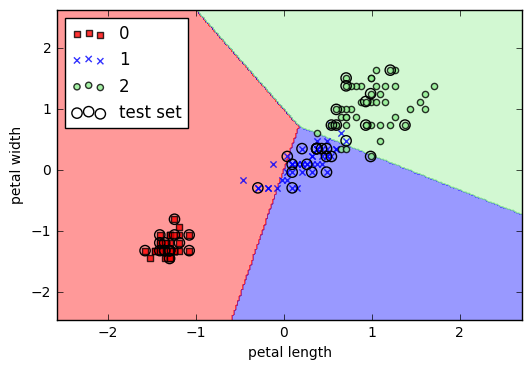

In [13]:
%matplotlib inline
from plot_decision_regions import plot_decision_regions
import matplotlib.pyplot as plt
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined_std, y_combined, classifier=ppn, test_idx=range(105, 150))
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend(loc="upper left")